In [1]:
%pip install accelerate>=0.26.0
%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install transformers datasets scikit-learn pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import torch
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments)
from transformers import BertForSequenceClassification
import numpy as np
from datasets import Dataset
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# ✅ Lista de modelos a probar
"""

model_names = [
      "bert-base-multilingual-cased"
]
"""
model_names = [
    "bert-base-multilingual-cased",
    "dccuchile/bert-base-spanish-wwm-uncased",
    "dccuchile/bert-base-spanish-wwm-cased",
    "xlm-roberta-base"
]

grid = [
    # 👇 Epochs más largos con LR bajo
    {"learning_rate": 2e-5, "batch_size": 16, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},
    {"learning_rate": 2e-5, "batch_size": 32, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},

    # 👇 LR intermedio con distintos batch
    {"learning_rate": 3e-5, "batch_size": 16, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.0},
    {"learning_rate": 3e-5, "batch_size": 32, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.1},
    {"learning_rate": 3e-5, "batch_size": 64, "epochs": 4, "weight_decay": 0.001, "warmup_ratio": 0.1},

    # 👇 Exploración con LR alto (arriesgado)
    {"learning_rate": 5e-5, "batch_size": 32, "epochs": 3, "weight_decay": 0.0, "warmup_ratio": 0.0},

    # 👇 Extra: bajo LR con batch más grande (si GPU lo aguanta)
    {"learning_rate": 1e-5, "batch_size": 32, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},
    {"learning_rate": 1e-5, "batch_size": 64, "epochs": 5, "weight_decay": 0.01, "warmup_ratio": 0.1},
]

In [5]:
# Verifica si hay GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ✅ Carga de datos
df = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\recursos\otros\BERT\diagnosticos_F20_F20.89_combinados.csv", sep="|")

# Fusiona columnas de diagnóstico en texto
diag_cols = [col for col in df.columns if col.startswith("Diag")]
df["text"] = df[diag_cols].fillna("").apply(lambda x: " ".join(x), axis=1)
df["label"] = df["DIAG PSQ"].apply(lambda x: 1 if "F20" in x and "F20.89" not in x else 0)
seed = int(time.time_ns() % (2**32))
seed=42
np.random.seed(seed)
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], stratify=df["label"], test_size=0.2, random_state=seed)
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})
print("Entrenamiento:", Counter(y_train))
print("Evaluación:", Counter(y_test))

Usando dispositivo: cuda
Entrenamiento: Counter({0: 1108, 1: 489})
Evaluación: Counter({0: 277, 1: 123})


Total ejemplos: 1997
Clases únicas: [0 1]


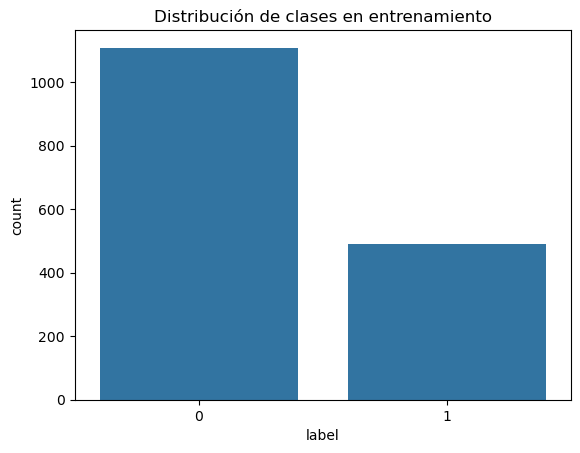

In [6]:
print(f"Total ejemplos: {len(df)}")
print(f"Clases únicas: {df['label'].unique()}")

sns.countplot(x=y_train)
plt.title("Distribución de clases en entrenamiento")
plt.show()

In [7]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds)
    }

def evaluate_model(model_name, learning_rate, batch_size, epochs, weight_decay, warmup_ratio):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

    train_tokenized = train_dataset.map(tokenize, batched=True)
    test_tokenized = test_dataset.map(tokenize, batched=True)

    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    training_args = TrainingArguments(
        output_dir="./results/BERT",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        eval_strategy="epoch",
        logging_steps=10,
        disable_tqdm=True,
        save_strategy="no",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()
    print(f"Evaluating {model_name} with learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
    print(f"Accuracy: {metrics['eval_accuracy']:.3f}, F1: {metrics['eval_f1']:.3f}, Precision: {metrics['eval_precision']:.3f}, Recall: {metrics['eval_recall']:.3f}")
    return metrics

In [8]:
# ✅ Loop para probar todos los modelos y combinaciones
resultados = []

for model_name in model_names:
    for params in grid:
        print(f"\n🔍 Probando modelo {model_name} con {params}")
        metrics = evaluate_model(model_name, **params)
        resultados.append({
            "modelo": model_name,
            "learning_rate": params["learning_rate"],
            "batch_size": params["batch_size"],
            "epochs": params["epochs"],
            "accuracy": metrics["eval_accuracy"],
            "f1": metrics["eval_f1"],
            "precision": metrics["eval_precision"],
            "recall": metrics["eval_recall"]
        })
        print(f"Accuracy: {metrics['eval_accuracy']:.3f}, F1: {metrics['eval_f1']:.3f}, Precision: {metrics['eval_precision']:.3f}, Recall: {metrics['eval_recall']:.3f}")

# ✅ Resultados ordenados
df_resultados = pd.DataFrame(resultados).sort_values(by="f1", ascending=False)
print("\n🏆 Mejores resultados por F1:")
print(df_resultados.head(10))

df_resultados["score"] = df_resultados["f1"] * 0.6 + df_resultados["recall"] * 0.4
df_ordenado = df_resultados.sort_values(by="score", ascending=False)
print("\n📊 Mejores modelos por score combinado (f1 + recall):")
print(df_ordenado.head(10))


🔍 Probando modelo bert-base-multilingual-cased con {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 5, 'weight_decay': 0.01, 'warmup_ratio': 0.1}


Map: 100%|██████████| 400/400 [00:00<00:00, 10545.54 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7126, 'grad_norm': 6.709595203399658, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.6534, 'grad_norm': 14.644060134887695, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6534, 'grad_norm': 14.644060134887695, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.563, 'grad_norm': 2.4493632316589355, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.563, 'grad_norm': 2.4493632316589355, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6442, 'grad_norm': 7.647410869598389, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6442, 'grad_norm': 7.647410869598389, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6178, 'grad_norm': 1.3426021337509155, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6178, 'grad_norm': 1.3426021337509155, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6215, 'grad_norm': 2.0120692253112793, 'learning_rate': 1.9600000000000002e-05,

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5860318541526794, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.293, 'eval_samples_per_second': 174.443, 'eval_steps_per_second': 10.903, 'epoch': 1.0}
{'loss': 0.5391, 'grad_norm': 3.246178150177002, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.5391, 'grad_norm': 3.246178150177002, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.5591, 'grad_norm': 4.349231243133545, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.5591, 'grad_norm': 4.349231243133545, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.5282, 'grad_norm': 5.356241703033447, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.5282, 'grad_norm': 5.356241703033447, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.4973, 'grad_norm': 5.86579704284668, 'learning_rate': 1.6044444444444444e-05, 'epoch': 1.4}
{'loss': 0.4973, 'grad_norm': 5.86579704284668, 'lear

Map: 100%|██████████| 400/400 [00:00<00:00, 10454.01 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7167, 'grad_norm': 1.480198860168457, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.6179, 'grad_norm': 4.388006210327148, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6179, 'grad_norm': 4.388006210327148, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6171, 'grad_norm': 1.3757365942001343, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6171, 'grad_norm': 1.3757365942001343, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6373, 'grad_norm': 1.5425282716751099, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.6373, 'grad_norm': 1.5425282716751099, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.5948, 'grad_norm': 2.376437187194824, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'loss': 0.5948, 'grad_norm': 2.376437187194824, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5977542996406555, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.3078, 'eval_samples_per_second': 173.326, 'eval_steps_per_second': 5.633, 'epoch': 1.0}
{'loss': 0.5993, 'grad_norm': 2.053126096725464, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.5993, 'grad_norm': 2.053126096725464, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.5852, 'grad_norm': 3.104376792907715, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.5852, 'grad_norm': 3.104376792907715, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.4961, 'grad_norm': 5.359586715698242, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.6}
{'loss': 0.4961, 'grad_norm': 5.359586715698242, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.6}
{'loss': 0.6223, 'grad_norm': 4.353092193603516, 'learning_rate': 1.4311111111111111e-05, 'epoch': 1.8}
{'loss': 0.6223, 'grad_norm': 4.353092193603516, 'le

Map: 100%|██████████| 400/400 [00:00<00:00, 11884.57 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6142, 'grad_norm': 2.0398495197296143, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.6111, 'grad_norm': 1.4737071990966797, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.6111, 'grad_norm': 1.4737071990966797, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.5993, 'grad_norm': 2.1473257541656494, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.5993, 'grad_norm': 2.1473257541656494, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.6381, 'grad_norm': 5.839104175567627, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.6381, 'grad_norm': 5.839104175567627, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.6028, 'grad_norm': 1.3421337604522705, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.6028, 'grad_norm': 1.3421337604522705, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.6148, 'grad_norm': 3.3665478229522705, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.6148, 'grad_norm': 3.3665478229522705

Map: 100%|██████████| 400/400 [00:00<00:00, 11805.63 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6578, 'grad_norm': 4.0573530197143555, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.6269, 'grad_norm': 5.065526962280273, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6269, 'grad_norm': 5.065526962280273, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6129, 'grad_norm': 2.5773470401763916, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6129, 'grad_norm': 2.5773470401763916, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6425, 'grad_norm': 1.5318942070007324, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.6425, 'grad_norm': 1.5318942070007324, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.582, 'grad_norm': 3.728261947631836, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}
{'loss': 0.582, 'grad_norm': 3.728261947631836, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6407543420791626, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.842, 'eval_samples_per_second': 217.15, 'eval_steps_per_second': 7.057, 'epoch': 1.0}
{'loss': 0.5966, 'grad_norm': 3.5339908599853516, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.5966, 'grad_norm': 3.5339908599853516, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.593, 'grad_norm': 1.7557586431503296, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.593, 'grad_norm': 1.7557586431503296, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.5371, 'grad_norm': 2.2070677280426025, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.5371, 'grad_norm': 2.2070677280426025, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.5564, 'grad_norm': 3.071709394454956, 'learning_rate': 1.8500000000000002e-05, 'epoch': 1.8}
{'loss': 0.5564, 'grad_norm': 3.07170939445495

Map: 100%|██████████| 400/400 [00:00<00:00, 11749.66 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6514, 'grad_norm': 3.2012460231781006, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.6445, 'grad_norm': 3.7489874362945557, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}
{'loss': 0.6445, 'grad_norm': 3.7489874362945557, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6109200119972229, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7594, 'eval_samples_per_second': 227.355, 'eval_steps_per_second': 3.979, 'epoch': 1.0}
{'loss': 0.6216, 'grad_norm': 4.757596015930176, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.6216, 'grad_norm': 4.757596015930176, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.6041, 'grad_norm': 0.8719131946563721, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.6041, 'grad_norm': 0.8719131946563721, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.6054, 'grad_norm': 1.071128010749817, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'loss': 0.6054, 'grad_norm': 1.071128010749817, 'learning_rate': 1.7e-05, 'epoch': 2.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5909176468849182, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8182, 'eval_samples_per_second': 219.993, 'eval_steps_per_second': 3.85, 'epoch': 2.0}
{'loss': 0.5623, 'grad_norm': 1.5609279870986938, 'learning_rate': 1.3666666666666667e-05, 'epoch': 2.4}
{'loss': 0.5623, 'grad_norm': 1.5609279870986938, 'learning_rate': 1.3666666666666667e-05, 'epoch': 2.4}
{'loss': 0.5422, 'grad_norm': 1.9859634637832642, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.8}
{'loss': 0.5422, 'grad_norm': 1.9859634637832642, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.8}
{'eval_loss': 0.5283710360527039, 'eval_accuracy': 0.755, 'eval_f1': 0.45555555555555555, 'eval_precision': 0.7192982456140351, 'eval_recall': 0.3333333333333333, 'eval_runtime': 1.771, 'eval_samples_per_second': 225.866, 'eval_steps_per_second': 3.953, 'epoch': 3.0}
{'eval_loss': 0.5283710360527039, 'eval_accuracy': 0.755, 'eval_f1': 0.45555555555555555,

Map: 100%|██████████| 400/400 [00:00<00:00, 11472.86 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6118, 'grad_norm': 16.74378204345703, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.6114, 'grad_norm': 2.625309944152832, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6114, 'grad_norm': 2.625309944152832, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6116, 'grad_norm': 2.617340326309204, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6116, 'grad_norm': 2.617340326309204, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6178, 'grad_norm': 1.9594707489013672, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.6178, 'grad_norm': 1.9594707489013672, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5875, 'grad_norm': 1.3376214504241943, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'loss': 0.5875, 'grad_norm': 1.3376214504241943, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6090795993804932, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8567, 'eval_samples_per_second': 215.438, 'eval_steps_per_second': 7.002, 'epoch': 1.0}
{'loss': 0.5943, 'grad_norm': 2.546943187713623, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.5943, 'grad_norm': 2.546943187713623, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.5693, 'grad_norm': 2.363234281539917, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.5693, 'grad_norm': 2.363234281539917, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.5482, 'grad_norm': 3.4323012828826904, 'learning_rate': 2.3666666666666668e-05, 'epoch': 1.6}
{'loss': 0.5482, 'grad_norm': 3.4323012828826904, 'learning_rate': 2.3666666666666668e-05, 'epoch': 1.6}
{'loss': 0.5875, 'grad_norm': 1.7136417627334595, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.8}
{'loss': 0.5875, 'grad_norm': 1.7136417627334

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5767799615859985, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8394, 'eval_samples_per_second': 217.46, 'eval_steps_per_second': 7.067, 'epoch': 2.0}
{'loss': 0.4966, 'grad_norm': 2.2773609161376953, 'learning_rate': 1.3666666666666666e-05, 'epoch': 2.2}
{'loss': 0.4966, 'grad_norm': 2.2773609161376953, 'learning_rate': 1.3666666666666666e-05, 'epoch': 2.2}
{'loss': 0.4673, 'grad_norm': 2.51755428314209, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.4}
{'loss': 0.4673, 'grad_norm': 2.51755428314209, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.4}
{'loss': 0.4749, 'grad_norm': 3.129743814468384, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.6}
{'loss': 0.4749, 'grad_norm': 3.129743814468384, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.6}
{'loss': 0.4493, 'grad_norm': 2.9719057083129883, 'learning_rate': 3.666666666666667e-06, 'epoch': 2.8}
{'loss': 0.4493, 'grad_norm': 2.9719057083129883, '

Map: 100%|██████████| 400/400 [00:00<00:00, 10114.49 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7109, 'grad_norm': 5.824907302856445, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6366, 'grad_norm': 2.4480106830596924, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6366, 'grad_norm': 2.4480106830596924, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6265, 'grad_norm': 4.677961349487305, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6265, 'grad_norm': 4.677961349487305, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6509, 'grad_norm': 4.910033702850342, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6509, 'grad_norm': 4.910033702850342, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6094, 'grad_norm': 1.4910627603530884, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}
{'loss': 0.6094, 'grad_norm': 1.4910627603530884, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6088958382606506, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.4009, 'eval_samples_per_second': 166.603, 'eval_steps_per_second': 5.415, 'epoch': 1.0}
{'loss': 0.6109, 'grad_norm': 1.6848407983779907, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.6109, 'grad_norm': 1.6848407983779907, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.624, 'grad_norm': 1.3312898874282837, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.624, 'grad_norm': 1.3312898874282837, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5579, 'grad_norm': 7.884701251983643, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.5579, 'grad_norm': 7.884701251983643, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.6534, 'grad_norm': 1.7202972173690796, 'learning_rate': 7.155555555555556e-06, 'epoch': 1.8}
{'loss': 0.6534, 'grad_norm': 1.7202972173690796, 'lea

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5939772129058838, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.9739, 'eval_samples_per_second': 202.642, 'eval_steps_per_second': 6.586, 'epoch': 2.0}
{'loss': 0.5677, 'grad_norm': 2.178537607192993, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.2}
{'loss': 0.5677, 'grad_norm': 2.178537607192993, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.2}
{'loss': 0.5406, 'grad_norm': 2.137526750564575, 'learning_rate': 5.822222222222223e-06, 'epoch': 2.4}
{'loss': 0.5406, 'grad_norm': 2.137526750564575, 'learning_rate': 5.822222222222223e-06, 'epoch': 2.4}
{'loss': 0.5563, 'grad_norm': 2.643749237060547, 'learning_rate': 5.3777777777777784e-06, 'epoch': 2.6}
{'loss': 0.5563, 'grad_norm': 2.643749237060547, 'learning_rate': 5.3777777777777784e-06, 'epoch': 2.6}
{'loss': 0.5271, 'grad_norm': 3.308954954147339, 'learning_rate': 4.933333333333334e-06, 'epoch': 2.8}
{'loss': 0.5271, 'grad_norm': 3.308954954147339, 'lea

Map: 100%|██████████| 400/400 [00:00<00:00, 11605.71 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7073, 'grad_norm': 1.2743030786514282, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6447, 'grad_norm': 1.0514109134674072, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'loss': 0.6447, 'grad_norm': 1.0514109134674072, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6109079122543335, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.4348, 'eval_samples_per_second': 164.286, 'eval_steps_per_second': 2.875, 'epoch': 1.0}
{'loss': 0.6056, 'grad_norm': 1.2652686834335327, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.6056, 'grad_norm': 1.2652686834335327, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5845, 'grad_norm': 2.0821001529693604, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.5845, 'grad_norm': 2.0821001529693604, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.6073, 'grad_norm': 1.7904220819473267, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}
{'loss': 0.6073, 'grad_norm': 1.7904220819473267, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5903562903404236, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.3798, 'eval_samples_per_second': 168.083, 'eval_steps_per_second': 2.941, 'epoch': 2.0}
{'loss': 0.5592, 'grad_norm': 2.897084951400757, 'learning_rate': 5.892857142857144e-06, 'epoch': 2.4}
{'loss': 0.5592, 'grad_norm': 2.897084951400757, 'learning_rate': 5.892857142857144e-06, 'epoch': 2.4}
{'loss': 0.5582, 'grad_norm': 2.54114031791687, 'learning_rate': 5e-06, 'epoch': 2.8}
{'loss': 0.5582, 'grad_norm': 2.54114031791687, 'learning_rate': 5e-06, 'epoch': 2.8}
{'eval_loss': 0.6072021126747131, 'eval_accuracy': 0.71, 'eval_f1': 0.12121212121212122, 'eval_precision': 0.8888888888888888, 'eval_recall': 0.06504065040650407, 'eval_runtime': 2.8177, 'eval_samples_per_second': 141.958, 'eval_steps_per_second': 2.484, 'epoch': 3.0}
{'eval_loss': 0.6072021126747131, 'eval_accuracy': 0.71, 'eval_f1': 0.12121212121212122, 'eval_precision': 0.8888888888888888, 'e

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 400/400 [00:00<00:00, 10355.99 examples/s]

Some weights of BertFor

{'loss': 0.6619, 'grad_norm': 4.81309700012207, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.6483, 'grad_norm': 7.304931640625, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6483, 'grad_norm': 7.304931640625, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.5628, 'grad_norm': 3.074141263961792, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.5628, 'grad_norm': 3.074141263961792, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6246, 'grad_norm': 6.506577491760254, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6246, 'grad_norm': 6.506577491760254, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6041, 'grad_norm': 3.0585625171661377, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6041, 'grad_norm': 3.0585625171661377, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.5793, 'grad_norm': 4.348196029663086, 'learning_rate': 1.9600000000000002e-05, 'epoch': 

Map: 100%|██████████| 400/400 [00:00<00:00, 10992.23 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6683, 'grad_norm': 4.694604396820068, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.6073, 'grad_norm': 3.4465742111206055, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6073, 'grad_norm': 3.4465742111206055, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6019, 'grad_norm': 2.759855270385742, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6019, 'grad_norm': 2.759855270385742, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6248, 'grad_norm': 2.7419631481170654, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.6248, 'grad_norm': 2.7419631481170654, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.5728, 'grad_norm': 3.2604737281799316, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'loss': 0.5728, 'grad_norm': 3.2604737281799316, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5808939933776855, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.5652, 'eval_samples_per_second': 155.932, 'eval_steps_per_second': 5.068, 'epoch': 1.0}
{'loss': 0.511, 'grad_norm': 3.9232826232910156, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.511, 'grad_norm': 3.9232826232910156, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.4987, 'grad_norm': 4.651359558105469, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.4987, 'grad_norm': 4.651359558105469, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.4559, 'grad_norm': 6.145792484283447, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.6}
{'loss': 0.4559, 'grad_norm': 6.145792484283447, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.6}
{'loss': 0.5368, 'grad_norm': 5.039278984069824, 'learning_rate': 1.4311111111111111e-05, 'epoch': 1.8}
{'loss': 0.5368, 'grad_norm': 5.039278984069824, 'le

Map: 100%|██████████| 400/400 [00:00<00:00, 10468.10 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5931, 'grad_norm': 2.6977789402008057, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.6094, 'grad_norm': 2.8589751720428467, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.6094, 'grad_norm': 2.8589751720428467, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.5952, 'grad_norm': 3.5234103202819824, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.5952, 'grad_norm': 3.5234103202819824, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.6514, 'grad_norm': 4.394638538360596, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.6514, 'grad_norm': 4.394638538360596, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.5934, 'grad_norm': 2.1784586906433105, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.5934, 'grad_norm': 2.1784586906433105, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.5634, 'grad_norm': 3.940695285797119, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.5634, 'grad_norm': 3.940695285797119, 

Map: 100%|██████████| 400/400 [00:00<00:00, 9497.43 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7081, 'grad_norm': 6.258556365966797, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.5937, 'grad_norm': 1.6308084726333618, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.5937, 'grad_norm': 1.6308084726333618, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6178, 'grad_norm': 3.3582801818847656, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6178, 'grad_norm': 3.3582801818847656, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6203, 'grad_norm': 2.797102689743042, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.6203, 'grad_norm': 2.797102689743042, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.576, 'grad_norm': 2.6113088130950928, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}
{'loss': 0.576, 'grad_norm': 2.6113088130950928, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.5645846724510193, 'eval_accuracy': 0.7, 'eva

Map: 100%|██████████| 400/400 [00:00<00:00, 10571.79 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6924, 'grad_norm': 5.188427925109863, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.6268, 'grad_norm': 1.2866308689117432, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}
{'loss': 0.6268, 'grad_norm': 1.2866308689117432, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}
{'eval_loss': 0.5812697410583496, 'eval_accuracy': 0.7025, 'eval_f1': 0.1793103448275862, 'eval_precision': 0.5909090909090909, 'eval_recall': 0.10569105691056911, 'eval_runtime': 3.0102, 'eval_samples_per_second': 132.882, 'eval_steps_per_second': 2.325, 'epoch': 1.0}
{'eval_loss': 0.5812697410583496, 'eval_accuracy': 0.7025, 'eval_f1': 0.1793103448275862, 'eval_precision': 0.5909090909090909, 'eval_recall': 0.10569105691056911, 'eval_runtime': 3.0102, 'eval_samples_per_second': 132.882, 'eval_steps_per_second': 2.325, 'epoch': 1.0}
{'loss': 0.5769, 'grad_norm': 1.706141710281372, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.5769, 'grad_norm': 1.7061417102

Map: 100%|██████████| 400/400 [00:00<00:00, 10652.74 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6278, 'grad_norm': 2.3844950199127197, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.6252, 'grad_norm': 5.664883613586426, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6252, 'grad_norm': 5.664883613586426, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6083, 'grad_norm': 2.143380641937256, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6083, 'grad_norm': 2.143380641937256, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6285, 'grad_norm': 4.13837194442749, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.6285, 'grad_norm': 4.13837194442749, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5392, 'grad_norm': 2.539494037628174, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'loss': 0.5392, 'grad_norm': 2.539494037628174, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.5002022981643677, 'eval_accuracy': 0.75, 'eval_f1': 0.3333333333333333, 'eval_precision': 0.9259

Map: 100%|██████████| 400/400 [00:00<00:00, 10438.79 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6463, 'grad_norm': 2.4666998386383057, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6214, 'grad_norm': 5.591734886169434, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6214, 'grad_norm': 5.591734886169434, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6085, 'grad_norm': 2.491097927093506, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6085, 'grad_norm': 2.491097927093506, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6235, 'grad_norm': 2.4687891006469727, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6235, 'grad_norm': 2.4687891006469727, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.5781, 'grad_norm': 2.7027788162231445, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}
{'loss': 0.5781, 'grad_norm': 2.7027788162231445, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5855562686920166, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 3.4031, 'eval_samples_per_second': 117.54, 'eval_steps_per_second': 3.82, 'epoch': 1.0}
{'loss': 0.5558, 'grad_norm': 3.5538136959075928, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.5558, 'grad_norm': 3.5538136959075928, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.5596, 'grad_norm': 3.738240957260132, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5596, 'grad_norm': 3.738240957260132, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5117, 'grad_norm': 6.034219264984131, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.5117, 'grad_norm': 6.034219264984131, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.5807, 'grad_norm': 3.7435879707336426, 'learning_rate': 7.155555555555556e-06, 'epoch': 1.8}
{'loss': 0.5807, 'grad_norm': 3.7435879707336426, 'learn

Map: 100%|██████████| 400/400 [00:00<00:00, 10779.29 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6593, 'grad_norm': 2.9593896865844727, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6379, 'grad_norm': 1.6933199167251587, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'loss': 0.6379, 'grad_norm': 1.6933199167251587, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'eval_loss': 0.5994651913642883, 'eval_accuracy': 0.695, 'eval_f1': 0.016129032258064516, 'eval_precision': 1.0, 'eval_recall': 0.008130081300813009, 'eval_runtime': 1.8748, 'eval_samples_per_second': 213.355, 'eval_steps_per_second': 3.734, 'epoch': 1.0}
{'eval_loss': 0.5994651913642883, 'eval_accuracy': 0.695, 'eval_f1': 0.016129032258064516, 'eval_precision': 1.0, 'eval_recall': 0.008130081300813009, 'eval_runtime': 1.8748, 'eval_samples_per_second': 213.355, 'eval_steps_per_second': 3.734, 'epoch': 1.0}
{'loss': 0.5969, 'grad_norm': 1.9981913566589355, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5969, 'grad_norm': 1.9981913566589355, 'learning_rate': 8.5

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 400/400 [00:00<00:00, 12181.50 examples/s]

Some weights of BertForSe

{'loss': 0.643, 'grad_norm': 3.8531291484832764, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.6365, 'grad_norm': 6.480917453765869, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6365, 'grad_norm': 6.480917453765869, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.5505, 'grad_norm': 2.5644989013671875, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.5505, 'grad_norm': 2.5644989013671875, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6174, 'grad_norm': 7.273244380950928, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6174, 'grad_norm': 7.273244380950928, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.5911, 'grad_norm': 3.547084093093872, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.5911, 'grad_norm': 3.547084093093872, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6065, 'grad_norm': 4.2703375816345215, 'learning_rate': 1.9600000000000002e-05, '

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5558857917785645, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.9772, 'eval_samples_per_second': 202.301, 'eval_steps_per_second': 12.644, 'epoch': 1.0}
{'loss': 0.4723, 'grad_norm': 3.9572136402130127, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.4723, 'grad_norm': 3.9572136402130127, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.4764, 'grad_norm': 6.440697193145752, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.4764, 'grad_norm': 6.440697193145752, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.5016, 'grad_norm': 10.284982681274414, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.5016, 'grad_norm': 10.284982681274414, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.465, 'grad_norm': 5.417587757110596, 'learning_rate': 1.6044444444444444e-05, 'epoch': 1.4}
{'loss': 0.465, 'grad_norm': 5.417587757110596, 

Map: 100%|██████████| 400/400 [00:00<00:00, 11923.77 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6413, 'grad_norm': 4.035714149475098, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.5971, 'grad_norm': 4.644626140594482, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.5971, 'grad_norm': 4.644626140594482, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6021, 'grad_norm': 3.0387625694274902, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6021, 'grad_norm': 3.0387625694274902, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6088, 'grad_norm': 2.51719331741333, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.6088, 'grad_norm': 2.51719331741333, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.5594, 'grad_norm': 3.1376049518585205, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'loss': 0.5594, 'grad_norm': 3.1376049518585205, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'eval_loss': 0.5907254815101624, 'eval_accuracy': 0.6875, 'ev

Map: 100%|██████████| 400/400 [00:00<00:00, 10453.88 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5979, 'grad_norm': 2.832695960998535, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.6022, 'grad_norm': 2.206228256225586, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.6022, 'grad_norm': 2.206228256225586, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.5988, 'grad_norm': 2.88198184967041, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.5988, 'grad_norm': 2.88198184967041, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.641, 'grad_norm': 4.563604354858398, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.641, 'grad_norm': 4.563604354858398, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.5927, 'grad_norm': 1.64702570438385, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.5927, 'grad_norm': 1.64702570438385, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.5854, 'grad_norm': 2.654362916946411, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.5854, 'grad_norm': 2.654362916946411, 'learning_rat

Map: 100%|██████████| 400/400 [00:00<00:00, 11746.45 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7386, 'grad_norm': 4.557659149169922, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.5953, 'grad_norm': 2.8072879314422607, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.5953, 'grad_norm': 2.8072879314422607, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6247, 'grad_norm': 3.080141305923462, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6247, 'grad_norm': 3.080141305923462, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6161, 'grad_norm': 4.420804977416992, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.6161, 'grad_norm': 4.420804977416992, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.5811, 'grad_norm': 1.9200607538223267, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}
{'loss': 0.5811, 'grad_norm': 1.9200607538223267, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5720652937889099, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.9172, 'eval_samples_per_second': 208.634, 'eval_steps_per_second': 6.781, 'epoch': 1.0}
{'loss': 0.5193, 'grad_norm': 3.8388190269470215, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.5193, 'grad_norm': 3.8388190269470215, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.5208, 'grad_norm': 4.041882514953613, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.5208, 'grad_norm': 4.041882514953613, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.5164, 'grad_norm': 5.892452716827393, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.5164, 'grad_norm': 5.892452716827393, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.5404, 'grad_norm': 3.8398444652557373, 'learning_rate': 1.8500000000000002e-05, 'epoch': 1.8}
{'loss': 0.5404, 'grad_norm': 3.8398444652557

Map: 100%|██████████| 400/400 [00:00<00:00, 12543.53 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.735, 'grad_norm': 5.749879837036133, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.632, 'grad_norm': 1.4621573686599731, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}
{'loss': 0.632, 'grad_norm': 1.4621573686599731, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.613991379737854, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8118, 'eval_samples_per_second': 220.776, 'eval_steps_per_second': 3.864, 'epoch': 1.0}
{'loss': 0.586, 'grad_norm': 2.675791025161743, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.586, 'grad_norm': 2.675791025161743, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.5602, 'grad_norm': 2.223923444747925, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.5602, 'grad_norm': 2.223923444747925, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.5704, 'grad_norm': 2.349562883377075, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'loss': 0.5704, 'grad_norm': 2.349562883377075, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'eval_loss': 0.5589029788970947, 'eval_accuracy': 0.7125, 'eval_f1': 0.31137724550898205, 'eval_precision': 0.5909090909090909, 'eval_recall': 0.21138211382113822, 'eval_runtime': 1.85

Map: 100%|██████████| 400/400 [00:00<00:00, 7765.43 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6169, 'grad_norm': 1.6085103750228882, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.5965, 'grad_norm': 3.2880938053131104, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.5965, 'grad_norm': 3.2880938053131104, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6006, 'grad_norm': 1.650145173072815, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6006, 'grad_norm': 1.650145173072815, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.5988, 'grad_norm': 4.772773742675781, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5988, 'grad_norm': 4.772773742675781, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.5386, 'grad_norm': 2.5877082347869873, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'loss': 0.5386, 'grad_norm': 2.5877082347869873, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'eval_loss': 0.520946741104126, 'eval_accuracy': 0.7425, 'eval_f1': 0.27972027972027974, 'eval_precision'

Map: 100%|██████████| 400/400 [00:00<00:00, 10556.16 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.757, 'grad_norm': 2.5694737434387207, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6281, 'grad_norm': 4.511112689971924, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6281, 'grad_norm': 4.511112689971924, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6141, 'grad_norm': 2.080801248550415, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6141, 'grad_norm': 2.080801248550415, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6368, 'grad_norm': 1.6963889598846436, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6368, 'grad_norm': 1.6963889598846436, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.5919, 'grad_norm': 1.8914376497268677, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}
{'loss': 0.5919, 'grad_norm': 1.8914376497268677, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.5968714356422424, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8375, 'eval_samples_per_second': 217.684, 'eval_steps_per_second': 7.075, 'epoch': 1.0}
{'loss': 0.5782, 'grad_norm': 1.7475899457931519, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.5782, 'grad_norm': 1.7475899457931519, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.5816, 'grad_norm': 2.491910696029663, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5816, 'grad_norm': 2.491910696029663, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5422, 'grad_norm': 3.627138376235962, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.5422, 'grad_norm': 3.627138376235962, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.6296, 'grad_norm': 2.393603563308716, 'learning_rate': 7.155555555555556e-06, 'epoch': 1.8}
{'loss': 0.6296, 'grad_norm': 2.393603563308716, 'learn

Map: 100%|██████████| 400/400 [00:00<00:00, 12195.14 examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.6351, 'grad_norm': 2.5174248218536377, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6337, 'grad_norm': 1.286849856376648, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'loss': 0.6337, 'grad_norm': 1.286849856376648, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'eval_loss': 0.5952003598213196, 'eval_accuracy': 0.69, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7351, 'eval_samples_per_second': 230.532, 'eval_steps_per_second': 4.034, 'epoch': 1.0}
{'eval_loss': 0.5952003598213196, 'eval_accuracy': 0.69, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7351, 'eval_samples_per_second': 230.532, 'eval_steps_per_second': 4.034, 'epoch': 1.0}
{'loss': 0.5905, 'grad_norm': 2.194453477859497, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5905, 'grad_norm': 2.194453477859497, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.5631, 'grad_norm': 1.91564011

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 400/400 [00:00<00:00, 14307.71 examples/s]

You are using a model of type xlm-roberta to in

{'loss': 0.6605, 'grad_norm': 3.8969497680664062, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.1}
{'loss': 0.6849, 'grad_norm': 6.422522068023682, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6849, 'grad_norm': 6.422522068023682, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.2}
{'loss': 0.6927, 'grad_norm': 4.330347537994385, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6927, 'grad_norm': 4.330347537994385, 'learning_rate': 1.16e-05, 'epoch': 0.3}
{'loss': 0.6614, 'grad_norm': 7.938748836517334, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6614, 'grad_norm': 7.938748836517334, 'learning_rate': 1.5600000000000003e-05, 'epoch': 0.4}
{'loss': 0.6255, 'grad_norm': 2.428081512451172, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6255, 'grad_norm': 2.428081512451172, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.5}
{'loss': 0.6507, 'grad_norm': 2.694296360015869, 'learning_rate': 1.9600000000000002e-05, 'ep

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6144677996635437, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8546, 'eval_samples_per_second': 215.676, 'eval_steps_per_second': 13.48, 'epoch': 1.0}
{'loss': 0.5943, 'grad_norm': 2.614492893218994, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.5943, 'grad_norm': 2.614492893218994, 'learning_rate': 1.737777777777778e-05, 'epoch': 1.1}
{'loss': 0.6432, 'grad_norm': 4.535750389099121, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.6432, 'grad_norm': 4.535750389099121, 'learning_rate': 1.6933333333333336e-05, 'epoch': 1.2}
{'loss': 0.6096, 'grad_norm': 3.038261651992798, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.6096, 'grad_norm': 3.038261651992798, 'learning_rate': 1.648888888888889e-05, 'epoch': 1.3}
{'loss': 0.6608, 'grad_norm': 2.9601454734802246, 'learning_rate': 1.6044444444444444e-05, 'epoch': 1.4}
{'loss': 0.6608, 'grad_norm': 2.9601454734802246, '

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6320136785507202, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8115, 'eval_samples_per_second': 220.814, 'eval_steps_per_second': 13.801, 'epoch': 2.0}
{'loss': 0.6548, 'grad_norm': 2.0636210441589355, 'learning_rate': 1.2933333333333334e-05, 'epoch': 2.1}
{'loss': 0.6548, 'grad_norm': 2.0636210441589355, 'learning_rate': 1.2933333333333334e-05, 'epoch': 2.1}
{'loss': 0.6118, 'grad_norm': 4.012869834899902, 'learning_rate': 1.2488888888888891e-05, 'epoch': 2.2}
{'loss': 0.6118, 'grad_norm': 4.012869834899902, 'learning_rate': 1.2488888888888891e-05, 'epoch': 2.2}
{'loss': 0.6175, 'grad_norm': 2.424635171890259, 'learning_rate': 1.2044444444444445e-05, 'epoch': 2.3}
{'loss': 0.6175, 'grad_norm': 2.424635171890259, 'learning_rate': 1.2044444444444445e-05, 'epoch': 2.3}
{'loss': 0.5601, 'grad_norm': 2.296349287033081, 'learning_rate': 1.16e-05, 'epoch': 2.4}
{'loss': 0.5601, 'grad_norm': 2.296349287033081, 'learning_

Map: 100%|██████████| 400/400 [00:00<00:00, 14395.11 examples/s]

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.e

{'loss': 0.7148, 'grad_norm': 9.40013313293457, 'learning_rate': 7.2000000000000005e-06, 'epoch': 0.2}
{'loss': 0.6214, 'grad_norm': 2.342320442199707, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6214, 'grad_norm': 2.342320442199707, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.4}
{'loss': 0.6348, 'grad_norm': 1.652684211730957, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6348, 'grad_norm': 1.652684211730957, 'learning_rate': 1.9644444444444447e-05, 'epoch': 0.6}
{'loss': 0.6657, 'grad_norm': 3.115722417831421, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.6657, 'grad_norm': 3.115722417831421, 'learning_rate': 1.8755555555555558e-05, 'epoch': 0.8}
{'loss': 0.6122, 'grad_norm': 1.6767326593399048, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}
{'loss': 0.6122, 'grad_norm': 1.6767326593399048, 'learning_rate': 1.7866666666666666e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6203057765960693, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8211, 'eval_samples_per_second': 219.653, 'eval_steps_per_second': 7.139, 'epoch': 1.0}
{'loss': 0.6208, 'grad_norm': 4.421715259552002, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.6208, 'grad_norm': 4.421715259552002, 'learning_rate': 1.697777777777778e-05, 'epoch': 1.2}
{'loss': 0.6446, 'grad_norm': 1.717058777809143, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.6446, 'grad_norm': 1.717058777809143, 'learning_rate': 1.608888888888889e-05, 'epoch': 1.4}
{'loss': 0.5948, 'grad_norm': 3.6688010692596436, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.6}
{'loss': 0.5948, 'grad_norm': 3.6688010692596436, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.6}
{'loss': 0.6736, 'grad_norm': 3.3294425010681152, 'learning_rate': 1.4311111111111111e-05, 'epoch': 1.8}
{'loss': 0.6736, 'grad_norm': 3.3294425010681152,

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6462193131446838, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8255, 'eval_samples_per_second': 219.122, 'eval_steps_per_second': 7.121, 'epoch': 2.0}
{'loss': 0.6376, 'grad_norm': 2.9319889545440674, 'learning_rate': 1.2533333333333336e-05, 'epoch': 2.2}
{'loss': 0.6376, 'grad_norm': 2.9319889545440674, 'learning_rate': 1.2533333333333336e-05, 'epoch': 2.2}
{'loss': 0.583, 'grad_norm': 1.2287237644195557, 'learning_rate': 1.1644444444444446e-05, 'epoch': 2.4}
{'loss': 0.583, 'grad_norm': 1.2287237644195557, 'learning_rate': 1.1644444444444446e-05, 'epoch': 2.4}
{'loss': 0.6112, 'grad_norm': 4.019757270812988, 'learning_rate': 1.0755555555555557e-05, 'epoch': 2.6}
{'loss': 0.6112, 'grad_norm': 4.019757270812988, 'learning_rate': 1.0755555555555557e-05, 'epoch': 2.6}
{'loss': 0.5967, 'grad_norm': 2.7198386192321777, 'learning_rate': 9.866666666666668e-06, 'epoch': 2.8}
{'loss': 0.5967, 'grad_norm': 2.71983861923217

Map: 100%|██████████| 400/400 [00:00<00:00, 13842.24 examples/s]

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.e

{'loss': 0.6745, 'grad_norm': 2.4323949813842773, 'learning_rate': 2.9325e-05, 'epoch': 0.1}
{'loss': 0.6101, 'grad_norm': 1.601730465888977, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.6101, 'grad_norm': 1.601730465888977, 'learning_rate': 2.8575e-05, 'epoch': 0.2}
{'loss': 0.619, 'grad_norm': 2.626741886138916, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.619, 'grad_norm': 2.626741886138916, 'learning_rate': 2.7825000000000002e-05, 'epoch': 0.3}
{'loss': 0.7164, 'grad_norm': 3.418626546859741, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.7164, 'grad_norm': 3.418626546859741, 'learning_rate': 2.7075e-05, 'epoch': 0.4}
{'loss': 0.6445, 'grad_norm': 1.5976248979568481, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.6445, 'grad_norm': 1.5976248979568481, 'learning_rate': 2.6325e-05, 'epoch': 0.5}
{'loss': 0.6519, 'grad_norm': 4.431457042694092, 'learning_rate': 2.5575e-05, 'epoch': 0.6}
{'loss': 0.6519, 'grad_norm': 4.431457042694092, 'learn

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6396524310112, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.1353, 'eval_samples_per_second': 187.33, 'eval_steps_per_second': 11.708, 'epoch': 1.0}
{'loss': 0.6018, 'grad_norm': 1.6499403715133667, 'learning_rate': 2.1825000000000002e-05, 'epoch': 1.1}
{'loss': 0.6018, 'grad_norm': 1.6499403715133667, 'learning_rate': 2.1825000000000002e-05, 'epoch': 1.1}
{'loss': 0.6405, 'grad_norm': 3.0846047401428223, 'learning_rate': 2.1075e-05, 'epoch': 1.2}
{'loss': 0.6405, 'grad_norm': 3.0846047401428223, 'learning_rate': 2.1075e-05, 'epoch': 1.2}
{'loss': 0.6265, 'grad_norm': 4.575854301452637, 'learning_rate': 2.0325e-05, 'epoch': 1.3}
{'loss': 0.6265, 'grad_norm': 4.575854301452637, 'learning_rate': 2.0325e-05, 'epoch': 1.3}
{'loss': 0.6637, 'grad_norm': 1.6287583112716675, 'learning_rate': 1.9574999999999998e-05, 'epoch': 1.4}
{'loss': 0.6637, 'grad_norm': 1.6287583112716675, 'learning_rate': 1.9574999999999998e-05, 'ep

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6449509263038635, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8985, 'eval_samples_per_second': 210.696, 'eval_steps_per_second': 13.168, 'epoch': 2.0}
{'loss': 0.6558, 'grad_norm': 1.457105040550232, 'learning_rate': 1.4325e-05, 'epoch': 2.1}
{'loss': 0.6558, 'grad_norm': 1.457105040550232, 'learning_rate': 1.4325e-05, 'epoch': 2.1}
{'loss': 0.6131, 'grad_norm': 4.403940677642822, 'learning_rate': 1.3575000000000001e-05, 'epoch': 2.2}
{'loss': 0.6131, 'grad_norm': 4.403940677642822, 'learning_rate': 1.3575000000000001e-05, 'epoch': 2.2}
{'loss': 0.6172, 'grad_norm': 2.690539836883545, 'learning_rate': 1.2825e-05, 'epoch': 2.3}
{'loss': 0.6172, 'grad_norm': 2.690539836883545, 'learning_rate': 1.2825e-05, 'epoch': 2.3}
{'loss': 0.5684, 'grad_norm': 1.9476629495620728, 'learning_rate': 1.2075e-05, 'epoch': 2.4}
{'loss': 0.5684, 'grad_norm': 1.9476629495620728, 'learning_rate': 1.2075e-05, 'epoch': 2.4}
{'loss': 0.63

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6264259815216064, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.9113, 'eval_samples_per_second': 209.279, 'eval_steps_per_second': 13.08, 'epoch': 3.0}
{'loss': 0.577, 'grad_norm': 1.9304380416870117, 'learning_rate': 6.825000000000001e-06, 'epoch': 3.1}
{'loss': 0.577, 'grad_norm': 1.9304380416870117, 'learning_rate': 6.825000000000001e-06, 'epoch': 3.1}
{'loss': 0.6545, 'grad_norm': 1.4960482120513916, 'learning_rate': 6.075e-06, 'epoch': 3.2}
{'loss': 0.6545, 'grad_norm': 1.4960482120513916, 'learning_rate': 6.075e-06, 'epoch': 3.2}
{'loss': 0.6229, 'grad_norm': 7.356293201446533, 'learning_rate': 5.325e-06, 'epoch': 3.3}
{'loss': 0.6229, 'grad_norm': 7.356293201446533, 'learning_rate': 5.325e-06, 'epoch': 3.3}
{'loss': 0.5869, 'grad_norm': 2.631629228591919, 'learning_rate': 4.575e-06, 'epoch': 3.4}
{'loss': 0.5869, 'grad_norm': 2.631629228591919, 'learning_rate': 4.575e-06, 'epoch': 3.4}
{'loss': 0.6095, 'grad

Map: 100%|██████████| 400/400 [00:00<00:00, 12017.89 examples/s]

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.e

{'loss': 0.7646, 'grad_norm': 9.656966209411621, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.2}
{'loss': 0.6128, 'grad_norm': 2.3863322734832764, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6128, 'grad_norm': 2.3863322734832764, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.4}
{'loss': 0.6273, 'grad_norm': 1.4050472974777222, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.6273, 'grad_norm': 1.4050472974777222, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.6}
{'loss': 0.665, 'grad_norm': 1.9592399597167969, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.665, 'grad_norm': 1.9592399597167969, 'learning_rate': 2.6833333333333336e-05, 'epoch': 0.8}
{'loss': 0.6155, 'grad_norm': 2.641568899154663, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}
{'loss': 0.6155, 'grad_norm': 2.641568899154663, 'learning_rate': 2.5166666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6267579793930054, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8646, 'eval_samples_per_second': 214.518, 'eval_steps_per_second': 6.972, 'epoch': 1.0}
{'loss': 0.6238, 'grad_norm': 4.428320407867432, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.6238, 'grad_norm': 4.428320407867432, 'learning_rate': 2.3500000000000002e-05, 'epoch': 1.2}
{'loss': 0.6322, 'grad_norm': 1.3639960289001465, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.6322, 'grad_norm': 1.3639960289001465, 'learning_rate': 2.1833333333333333e-05, 'epoch': 1.4}
{'loss': 0.6191, 'grad_norm': 4.325741291046143, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.6191, 'grad_norm': 4.325741291046143, 'learning_rate': 2.0166666666666668e-05, 'epoch': 1.6}
{'loss': 0.6786, 'grad_norm': 1.5309842824935913, 'learning_rate': 1.8500000000000002e-05, 'epoch': 1.8}
{'loss': 0.6786, 'grad_norm': 1.5309842824935

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6390163898468018, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8134, 'eval_samples_per_second': 220.581, 'eval_steps_per_second': 7.169, 'epoch': 2.0}
{'loss': 0.6306, 'grad_norm': 3.857156276702881, 'learning_rate': 1.5166666666666667e-05, 'epoch': 2.2}
{'loss': 0.6306, 'grad_norm': 3.857156276702881, 'learning_rate': 1.5166666666666667e-05, 'epoch': 2.2}
{'loss': 0.5736, 'grad_norm': 1.0680482387542725, 'learning_rate': 1.3500000000000001e-05, 'epoch': 2.4}
{'loss': 0.5736, 'grad_norm': 1.0680482387542725, 'learning_rate': 1.3500000000000001e-05, 'epoch': 2.4}
{'loss': 0.5796, 'grad_norm': 1.2894624471664429, 'learning_rate': 1.1833333333333332e-05, 'epoch': 2.6}
{'loss': 0.5796, 'grad_norm': 1.2894624471664429, 'learning_rate': 1.1833333333333332e-05, 'epoch': 2.6}
{'loss': 0.5692, 'grad_norm': 7.590763568878174, 'learning_rate': 1.0166666666666667e-05, 'epoch': 2.8}
{'loss': 0.5692, 'grad_norm': 7.590763568878

Map: 100%|██████████| 400/400 [00:00<00:00, 14530.38 examples/s]
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.en

{'loss': 0.7105, 'grad_norm': 2.467400550842285, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.4}
{'loss': 0.664, 'grad_norm': 4.490408897399902, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}
{'loss': 0.664, 'grad_norm': 4.490408897399902, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.7294327616691589, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7907, 'eval_samples_per_second': 223.38, 'eval_steps_per_second': 3.909, 'epoch': 1.0}
{'loss': 0.6425, 'grad_norm': 1.7330858707427979, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.6425, 'grad_norm': 1.7330858707427979, 'learning_rate': 2.3666666666666665e-05, 'epoch': 1.2}
{'loss': 0.6234, 'grad_norm': 2.5344722270965576, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.6234, 'grad_norm': 2.5344722270965576, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.6}
{'loss': 0.6638, 'grad_norm': 2.005427360534668, 'learning_rate': 1.7e-05, 'epoch': 2.0}
{'loss': 0.6638, 'grad_norm': 2.005427360534668, 'learning_rate': 1.7e-05, 'epoch': 2.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6180431842803955, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7927, 'eval_samples_per_second': 223.122, 'eval_steps_per_second': 3.905, 'epoch': 2.0}
{'loss': 0.6061, 'grad_norm': 0.8549360632896423, 'learning_rate': 1.3666666666666667e-05, 'epoch': 2.4}
{'loss': 0.6061, 'grad_norm': 0.8549360632896423, 'learning_rate': 1.3666666666666667e-05, 'epoch': 2.4}
{'loss': 0.6062, 'grad_norm': 1.373694896697998, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.8}
{'loss': 0.6062, 'grad_norm': 1.373694896697998, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6188493967056274, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.865, 'eval_samples_per_second': 214.478, 'eval_steps_per_second': 3.753, 'epoch': 3.0}
{'loss': 0.6307, 'grad_norm': 1.3622300624847412, 'learning_rate': 7e-06, 'epoch': 3.2}
{'loss': 0.6307, 'grad_norm': 1.3622300624847412, 'learning_rate': 7e-06, 'epoch': 3.2}
{'loss': 0.6265, 'grad_norm': 0.6999104619026184, 'learning_rate': 3.6666666666666666e-06, 'epoch': 3.6}
{'loss': 0.6265, 'grad_norm': 0.6999104619026184, 'learning_rate': 3.6666666666666666e-06, 'epoch': 3.6}
{'loss': 0.6106, 'grad_norm': 1.8948309421539307, 'learning_rate': 3.3333333333333335e-07, 'epoch': 4.0}
{'loss': 0.6106, 'grad_norm': 1.8948309421539307, 'learning_rate': 3.3333333333333335e-07, 'epoch': 4.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6103407740592957, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7925, 'eval_samples_per_second': 223.153, 'eval_steps_per_second': 3.905, 'epoch': 4.0}
{'train_runtime': 97.2447, 'train_samples_per_second': 65.69, 'train_steps_per_second': 1.028, 'train_loss': 0.6384122562408447, 'epoch': 4.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6103407740592957, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8592, 'eval_samples_per_second': 215.146, 'eval_steps_per_second': 3.765, 'epoch': 4.0}
Evaluating xlm-roberta-base with learning_rate=3e-05, batch_size=64, epochs=4
Accuracy: 0.693, F1: 0.000, Precision: 0.000, Recall: 0.000
Accuracy: 0.693, F1: 0.000, Precision: 0.000, Recall: 0.000

🔍 Probando modelo xlm-roberta-base con {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.0, 'warmup_ratio': 0.0}


Map: 100%|██████████| 400/400 [00:00<00:00, 14155.36 examples/s]
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.en

{'loss': 0.7317, 'grad_norm': 4.050017356872559, 'learning_rate': 4.7e-05, 'epoch': 0.2}
{'loss': 0.6194, 'grad_norm': 2.5303831100463867, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6194, 'grad_norm': 2.5303831100463867, 'learning_rate': 4.3666666666666666e-05, 'epoch': 0.4}
{'loss': 0.6383, 'grad_norm': 3.0427966117858887, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6383, 'grad_norm': 3.0427966117858887, 'learning_rate': 4.0333333333333336e-05, 'epoch': 0.6}
{'loss': 0.6669, 'grad_norm': 1.3271069526672363, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.6669, 'grad_norm': 1.3271069526672363, 'learning_rate': 3.7e-05, 'epoch': 0.8}
{'loss': 0.6104, 'grad_norm': 2.082787275314331, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}
{'loss': 0.6104, 'grad_norm': 2.082787275314331, 'learning_rate': 3.366666666666667e-05, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6296570301055908, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8008, 'eval_samples_per_second': 222.125, 'eval_steps_per_second': 7.219, 'epoch': 1.0}
{'loss': 0.6293, 'grad_norm': 3.0357282161712646, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.6293, 'grad_norm': 3.0357282161712646, 'learning_rate': 3.0333333333333337e-05, 'epoch': 1.2}
{'loss': 0.6387, 'grad_norm': 1.020343542098999, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.6387, 'grad_norm': 1.020343542098999, 'learning_rate': 2.7000000000000002e-05, 'epoch': 1.4}
{'loss': 0.5976, 'grad_norm': 2.6675281524658203, 'learning_rate': 2.3666666666666668e-05, 'epoch': 1.6}
{'loss': 0.5976, 'grad_norm': 2.6675281524658203, 'learning_rate': 2.3666666666666668e-05, 'epoch': 1.6}
{'loss': 0.6851, 'grad_norm': 1.6353718042373657, 'learning_rate': 2.0333333333333334e-05, 'epoch': 1.8}
{'loss': 0.6851, 'grad_norm': 1.63537180423

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6235035061836243, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8079, 'eval_samples_per_second': 221.253, 'eval_steps_per_second': 7.191, 'epoch': 2.0}
{'loss': 0.6364, 'grad_norm': 1.0784341096878052, 'learning_rate': 1.3666666666666666e-05, 'epoch': 2.2}
{'loss': 0.6364, 'grad_norm': 1.0784341096878052, 'learning_rate': 1.3666666666666666e-05, 'epoch': 2.2}
{'loss': 0.6044, 'grad_norm': 2.059802293777466, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.4}
{'loss': 0.6044, 'grad_norm': 2.059802293777466, 'learning_rate': 1.0333333333333333e-05, 'epoch': 2.4}
{'loss': 0.6058, 'grad_norm': 0.893485426902771, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.6}
{'loss': 0.6058, 'grad_norm': 0.893485426902771, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.6}
{'loss': 0.5977, 'grad_norm': 2.0724477767944336, 'learning_rate': 3.666666666666667e-06, 'epoch': 2.8}
{'loss': 0.5977, 'grad_norm': 2.0724477767944336

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6181089878082275, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7947, 'eval_samples_per_second': 222.881, 'eval_steps_per_second': 7.244, 'epoch': 3.0}
{'train_runtime': 81.0814, 'train_samples_per_second': 59.089, 'train_steps_per_second': 1.85, 'train_loss': 0.6352915287017822, 'epoch': 3.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6181089878082275, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8261, 'eval_samples_per_second': 219.051, 'eval_steps_per_second': 7.119, 'epoch': 3.0}
Evaluating xlm-roberta-base with learning_rate=5e-05, batch_size=32, epochs=3
Accuracy: 0.693, F1: 0.000, Precision: 0.000, Recall: 0.000
Accuracy: 0.693, F1: 0.000, Precision: 0.000, Recall: 0.000

🔍 Probando modelo xlm-roberta-base con {'learning_rate': 1e-05, 'batch_size': 32, 'epochs': 5, 'weight_decay': 0.01, 'warmup_ratio': 0.1}


Map: 100%|██████████| 400/400 [00:00<00:00, 15126.74 examples/s]
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.en

{'loss': 0.7519, 'grad_norm': 8.421727180480957, 'learning_rate': 3.6000000000000003e-06, 'epoch': 0.2}
{'loss': 0.6186, 'grad_norm': 2.720026731491089, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6186, 'grad_norm': 2.720026731491089, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.4}
{'loss': 0.6521, 'grad_norm': 6.329633712768555, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6521, 'grad_norm': 6.329633712768555, 'learning_rate': 9.822222222222223e-06, 'epoch': 0.6}
{'loss': 0.6642, 'grad_norm': 3.2061758041381836, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6642, 'grad_norm': 3.2061758041381836, 'learning_rate': 9.377777777777779e-06, 'epoch': 0.8}
{'loss': 0.6029, 'grad_norm': 2.2747647762298584, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}
{'loss': 0.6029, 'grad_norm': 2.2747647762298584, 'learning_rate': 8.933333333333333e-06, 'epoch': 1.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6123380064964294, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8105, 'eval_samples_per_second': 220.932, 'eval_steps_per_second': 7.18, 'epoch': 1.0}
{'loss': 0.6213, 'grad_norm': 2.767796277999878, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.6213, 'grad_norm': 2.767796277999878, 'learning_rate': 8.48888888888889e-06, 'epoch': 1.2}
{'loss': 0.6228, 'grad_norm': 1.8138246536254883, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.6228, 'grad_norm': 1.8138246536254883, 'learning_rate': 8.044444444444444e-06, 'epoch': 1.4}
{'loss': 0.5839, 'grad_norm': 5.4719624519348145, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.5839, 'grad_norm': 5.4719624519348145, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.6}
{'loss': 0.6749, 'grad_norm': 2.525385618209839, 'learning_rate': 7.155555555555556e-06, 'epoch': 1.8}
{'loss': 0.6749, 'grad_norm': 2.525385618209839, 'lear

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6479634046554565, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8248, 'eval_samples_per_second': 219.198, 'eval_steps_per_second': 7.124, 'epoch': 2.0}
{'loss': 0.6318, 'grad_norm': 4.34548807144165, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.2}
{'loss': 0.6318, 'grad_norm': 4.34548807144165, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.2}
{'loss': 0.5781, 'grad_norm': 1.4984151124954224, 'learning_rate': 5.822222222222223e-06, 'epoch': 2.4}
{'loss': 0.5781, 'grad_norm': 1.4984151124954224, 'learning_rate': 5.822222222222223e-06, 'epoch': 2.4}
{'loss': 0.6048, 'grad_norm': 4.001221656799316, 'learning_rate': 5.3777777777777784e-06, 'epoch': 2.6}
{'loss': 0.6048, 'grad_norm': 4.001221656799316, 'learning_rate': 5.3777777777777784e-06, 'epoch': 2.6}
{'loss': 0.6033, 'grad_norm': 5.029198169708252, 'learning_rate': 4.933333333333334e-06, 'epoch': 2.8}
{'loss': 0.6033, 'grad_norm': 5.029198169708252, 'lea

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6001319289207458, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 2.045, 'eval_samples_per_second': 195.597, 'eval_steps_per_second': 6.357, 'epoch': 4.0}
{'loss': 0.5608, 'grad_norm': 3.9940011501312256, 'learning_rate': 1.8222222222222225e-06, 'epoch': 4.2}
{'loss': 0.5608, 'grad_norm': 3.9940011501312256, 'learning_rate': 1.8222222222222225e-06, 'epoch': 4.2}
{'loss': 0.5691, 'grad_norm': 6.43960428237915, 'learning_rate': 1.377777777777778e-06, 'epoch': 4.4}
{'loss': 0.5691, 'grad_norm': 6.43960428237915, 'learning_rate': 1.377777777777778e-06, 'epoch': 4.4}
{'loss': 0.569, 'grad_norm': 12.785064697265625, 'learning_rate': 9.333333333333334e-07, 'epoch': 4.6}
{'loss': 0.569, 'grad_norm': 12.785064697265625, 'learning_rate': 9.333333333333334e-07, 'epoch': 4.6}
{'loss': 0.5693, 'grad_norm': 2.093233823776245, 'learning_rate': 4.88888888888889e-07, 'epoch': 4.8}
{'loss': 0.5693, 'grad_norm': 2.093233823776245, 'learn

Map: 100%|██████████| 400/400 [00:00<00:00, 14053.15 examples/s]
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.en

{'loss': 0.7107, 'grad_norm': 9.254273414611816, 'learning_rate': 6.923076923076923e-06, 'epoch': 0.4}
{'loss': 0.6892, 'grad_norm': 5.0753397941589355, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}
{'loss': 0.6892, 'grad_norm': 5.0753397941589355, 'learning_rate': 9.464285714285714e-06, 'epoch': 0.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6433813571929932, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7829, 'eval_samples_per_second': 224.351, 'eval_steps_per_second': 3.926, 'epoch': 1.0}
{'loss': 0.6267, 'grad_norm': 2.7898166179656982, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.6267, 'grad_norm': 2.7898166179656982, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.2}
{'loss': 0.633, 'grad_norm': 2.159406900405884, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.633, 'grad_norm': 2.159406900405884, 'learning_rate': 7.67857142857143e-06, 'epoch': 1.6}
{'loss': 0.6268, 'grad_norm': 1.1430134773254395, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}
{'loss': 0.6268, 'grad_norm': 1.1430134773254395, 'learning_rate': 6.785714285714287e-06, 'epoch': 2.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6140100955963135, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8447, 'eval_samples_per_second': 216.842, 'eval_steps_per_second': 3.795, 'epoch': 2.0}
{'loss': 0.6052, 'grad_norm': 2.1834588050842285, 'learning_rate': 5.892857142857144e-06, 'epoch': 2.4}
{'loss': 0.6052, 'grad_norm': 2.1834588050842285, 'learning_rate': 5.892857142857144e-06, 'epoch': 2.4}
{'loss': 0.6019, 'grad_norm': 1.6432008743286133, 'learning_rate': 5e-06, 'epoch': 2.8}
{'loss': 0.6019, 'grad_norm': 1.6432008743286133, 'learning_rate': 5e-06, 'epoch': 2.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6133333444595337, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8628, 'eval_samples_per_second': 214.735, 'eval_steps_per_second': 3.758, 'epoch': 3.0}
{'loss': 0.6304, 'grad_norm': 1.6215578317642212, 'learning_rate': 4.107142857142857e-06, 'epoch': 3.2}
{'loss': 0.6304, 'grad_norm': 1.6215578317642212, 'learning_rate': 4.107142857142857e-06, 'epoch': 3.2}
{'loss': 0.6189, 'grad_norm': 1.0927830934524536, 'learning_rate': 3.2142857142857147e-06, 'epoch': 3.6}
{'loss': 0.6189, 'grad_norm': 1.0927830934524536, 'learning_rate': 3.2142857142857147e-06, 'epoch': 3.6}
{'loss': 0.6046, 'grad_norm': 2.3760883808135986, 'learning_rate': 2.321428571428572e-06, 'epoch': 4.0}
{'loss': 0.6046, 'grad_norm': 2.3760883808135986, 'learning_rate': 2.321428571428572e-06, 'epoch': 4.0}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6039621233940125, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8301, 'eval_samples_per_second': 218.565, 'eval_steps_per_second': 3.825, 'epoch': 4.0}
{'loss': 0.6088, 'grad_norm': 3.0201730728149414, 'learning_rate': 1.4285714285714286e-06, 'epoch': 4.4}
{'loss': 0.6088, 'grad_norm': 3.0201730728149414, 'learning_rate': 1.4285714285714286e-06, 'epoch': 4.4}
{'loss': 0.6037, 'grad_norm': 2.534403085708618, 'learning_rate': 5.357142857142857e-07, 'epoch': 4.8}
{'loss': 0.6037, 'grad_norm': 2.534403085708618, 'learning_rate': 5.357142857142857e-07, 'epoch': 4.8}


c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


{'eval_loss': 0.6009204983711243, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.8088, 'eval_samples_per_second': 221.143, 'eval_steps_per_second': 3.87, 'epoch': 5.0}
{'train_runtime': 122.8204, 'train_samples_per_second': 65.014, 'train_steps_per_second': 1.018, 'train_loss': 0.6287404556274414, 'epoch': 5.0}
{'eval_loss': 0.6009204983711243, 'eval_accuracy': 0.6925, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_runtime': 1.7781, 'eval_samples_per_second': 224.963, 'eval_steps_per_second': 3.937, 'epoch': 5.0}
Evaluating xlm-roberta-base with learning_rate=1e-05, batch_size=64, epochs=5
Accuracy: 0.693, F1: 0.000, Precision: 0.000, Recall: 0.000
Accuracy: 0.693, F1: 0.000, Precision: 0.000, Recall: 0.000

🏆 Mejores resultados por F1:
                                     modelo  learning_rate  batch_size  \
8   dccuchile/bert-base-spanish-wwm-uncased        0.00002          16   
18    dccuchile/bert-base-spanis

c:\Users\Usuario\miniforge3\envs\alba\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
